In [1]:
import os
import glob
import numpy as np
from scipy import ndimage
from IPython.display import Audio
from scipy.io import wavfile
import matplotlib.pyplot as plt
import librosa

In [2]:
data_folder = '/home/beiming/Desktop/Parsed_data'
group_name = 'ENF' # ENF or ENM
group_folder = os.path.join(data_folder, group_name)
subject_list = os.listdir(group_folder) 
print(subject_list)

['09ENF', '40ENF', '37ENF', '36ENF', '05ENF', '17ENF', '07ENF', '18ENF', '21ENF', '28ENF']


In [3]:
#Choose subject ID based on the print above
sub_name = '40ENF'

data_sub_folder = os.path.join(group_folder, sub_name)

In [4]:
WAV_path_list = os.path.join(data_sub_folder, '*' + '.wav')
WAV_path_list = glob.glob(WAV_path_list)
WAV_path_list.sort()

EMA_path_list = os.path.join(data_sub_folder, '*' + '.ema')
EMA_path_list = glob.glob(EMA_path_list)
EMA_path_list.sort()

In [140]:

I, fs = librosa.load(WAV_path_list[0], sr = 16000)

#fs, I = wavfile.read(WAV_path_list[0])

print(len(WAV_path_list))

148


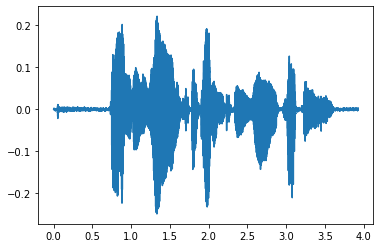

In [141]:
Audio(I.astype(np.float64), rate = fs)
I_time = np.arange(0,len(I))/fs
plt.plot(I_time,I)

In [7]:
Audio(I.astype(np.float64), rate = fs)

In [8]:
# Sampling rate of EMA is 400Hz
MV = np.loadtxt(EMA_path_list[0])
print(MV.shape)
print(len(I)/fs)

(1366, 21)
3.415875


In [11]:
import pyworld
import pysptk
import nnmnkwii

In [8]:
mgc_dim = 40
lf0_dim = 1
vuv_dim = 1
bap_dim = 1

fs = 16000

frame_period = 5
hop_length = 80
fftlen = 1024
alpha = 0.41

order = 39
frame_period = 5
windows = [
    (0, 0, np.array([1.0])),
    (1, 1, np.array([-0.5, 0.0, 0.5])),
    (1, 1, np.array([1.0, -2.0, 1.0])),
]

In [11]:
I = I.astype(np.float64)
f0, timeaxis = pyworld.dio(I, fs, frame_period=frame_period)
f0 = pyworld.stonemask(I, f0, timeaxis, fs)
spectrogram = pyworld.cheaptrick(I, f0, timeaxis, fs)
aperiodicity = pyworld.d4c(I, f0, timeaxis, fs)

bap = pyworld.code_aperiodicity(aperiodicity, fs)
mgc = pysptk.sp2mc(spectrogram, order=order, alpha=pysptk.util.mcepalpha(fs))

In [12]:
spectrogram = pysptk.mc2sp(mgc, fftlen=fftlen, alpha=alpha)
aperiodicity = pyworld.decode_aperiodicity(bap.astype(np.float64), fs, fftlen)

generated_waveform = pyworld.synthesize(f0.flatten().astype(np.float64),
                                        spectrogram.astype(np.float64),
                                        aperiodicity.astype(np.float64),
                                        fs, frame_period)

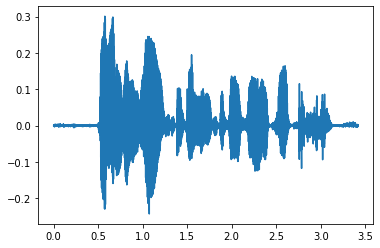

In [13]:
I_time = np.arange(0,len(generated_waveform))/fs
plt.plot(I_time,generated_waveform)

In [14]:
Audio(generated_waveform.astype(np.float64), rate = fs)

In [14]:
#Testing delta
import numpy as np
from nnmnkwii.preprocessing.f0 import interp1d
from nnmnkwii.util import apply_delta_windows



In [16]:
mgc_head = delta_features[:, 0:mgc_dim]
lf0_head = delta_features[:, mgc_dim*3:mgc_dim*3+lf0_dim]
vuv_head = delta_features[:, mgc_dim*3+lf0_dim*3:mgc_dim*3+lf0_dim*3+1]
bap_head = delta_features[:, mgc_dim*3+lf0_dim*3+1:mgc_dim*3+lf0_dim*3+1+bap_dim]

f0 = lf0_head.copy()
f0[vuv_head < 0.5] = 0
f0[np.nonzero(f0)] = np.exp(f0[np.nonzero(f0)])

In [17]:
spectrogram = pysptk.mc2sp(mgc_head, fftlen=fftlen, alpha=alpha)
aperiodicity = pyworld.decode_aperiodicity(bap_head.astype(np.float64), fs, fftlen)

generated_waveform = pyworld.synthesize(f0.flatten().astype(np.float64),
                                        spectrogram.astype(np.float64),
                                        aperiodicity.astype(np.float64),
                                        fs, frame_period)
Audio(generated_waveform.astype(np.float64), rate = fs)

## ATS Experiments (With Tensorflow)

In [5]:
file_num = len(WAV_path_list)

train_index = range(file_num - 20)
valid_index = range(file_num - 20, file_num - 10)
test_index = range(file_num - 10, file_num)

In [6]:
def collect_features(wav_path, fs, frame_period, order):
  
    x, sr = librosa.load(wav_path, sr = fs)
    x = x.astype(np.float64)
    f0, timeaxis = pyworld.dio(x, fs, frame_period=frame_period)
    f0 = pyworld.stonemask(x, f0, timeaxis, fs)
    spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
    aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)

    bap = pyworld.code_aperiodicity(aperiodicity, fs)
    mgc = pysptk.sp2mc(spectrogram, order=order,
                       alpha=pysptk.util.mcepalpha(fs))
    f0 = f0[:, None]
    lf0 = f0.copy()
    nonzero_indices = np.nonzero(f0)
    lf0[nonzero_indices] = np.log(f0[nonzero_indices])
    vuv = (lf0 != 0).astype(np.float32)
    lf0 = interp1d(lf0, kind="slinear")
    
    lf0 = f0.copy()
    nonzero_indices = np.nonzero(f0)
    lf0[nonzero_indices] = np.log(f0[nonzero_indices])
    vuv = (lf0 != 0).astype(np.float32)
    lf0 = interp1d(lf0, kind="slinear")

    lf0 = lf0.reshape(lf0.shape[0],1)
    vuv = vuv.reshape(vuv.shape[0],1)

    mgc_delta = apply_delta_windows(mgc, windows)
    lf0_delta = apply_delta_windows(lf0, windows)
    bap_delta = apply_delta_windows(bap, windows)
    
    features = np.hstack((mgc, lf0, vuv, bap))

    delta_features = np.hstack((mgc_delta, lf0_delta, vuv, bap_delta))
    
    return features, delta_features

In [20]:
features, delta_features = collect_features(WAV_path_list[0], fs, frame_period, order)

mgc_head = delta_features[:, 0:mgc_dim]
lf0_head = delta_features[:, mgc_dim*3:mgc_dim*3+lf0_dim]
vuv_head = delta_features[:, mgc_dim*3+lf0_dim*3:mgc_dim*3+lf0_dim*3+1]
bap_head = delta_features[:, mgc_dim*3+lf0_dim*3+1:mgc_dim*3+lf0_dim*3+1+bap_dim]

f0 = lf0_head.copy()
f0[vuv_head < 0.5] = 0
f0[np.nonzero(f0)] = np.exp(f0[np.nonzero(f0)])

spectrogram = pysptk.mc2sp(mgc_head, fftlen=fftlen, alpha=alpha)
aperiodicity = pyworld.decode_aperiodicity(bap_head.astype(np.float64), fs, fftlen)

generated_waveform = pyworld.synthesize(f0.flatten().astype(np.float64),
                                        spectrogram.astype(np.float64),
                                        aperiodicity.astype(np.float64),
                                        fs, frame_period)
Audio(generated_waveform.astype(np.float64), rate = fs)

In [15]:
Valid_MV = {}
Valid_WAV = {}

index = 0

for i in valid_index:
  
  MV = np.loadtxt(EMA_path_list[i])
  
  WAV, WAV_delta = collect_features(WAV_path_list[i], fs,  frame_period, order)

  scale_ratio = WAV.shape[0] / MV.shape[0]


  MV_align = np.empty([WAV.shape[0], MV.shape[1]])

  for j in range(MV.shape[1]):

    MV_align[:,j] = ndimage.zoom(MV[:,j], scale_ratio)
    
  MV_delta = apply_delta_windows(MV_align, windows)
  
  
  Valid_MV[index] = MV_delta
  Valid_WAV[index] = WAV_delta
  
  index = index + 1  

/home/beiming/.local/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [16]:
Test_MV = {}
Test_WAV = {}

index = 0

for i in test_index:
  
  MV = np.loadtxt(EMA_path_list[i])
  
  WAV, WAV_delta = collect_features(WAV_path_list[i], fs,  frame_period, order)

  scale_ratio = WAV.shape[0] / MV.shape[0]


  MV_align = np.empty([WAV.shape[0], MV.shape[1]])

  for j in range(MV.shape[1]):

    MV_align[:,j] = ndimage.zoom(MV[:,j], scale_ratio)
    
  MV_delta = apply_delta_windows(MV_align, windows)
  
  
  Test_MV[index] = MV_delta
  Test_WAV[index] = WAV_delta
  
  index = index + 1  

In [17]:
Train_MV = {}
Train_WAV = {}

index = 0

for i in train_index:
  
  MV = np.loadtxt(EMA_path_list[i])
  
  WAV, WAV_delta = collect_features(WAV_path_list[i], fs,  frame_period, order)

  scale_ratio = WAV.shape[0] / MV.shape[0]


  MV_align = np.empty([WAV.shape[0], MV.shape[1]])

  for j in range(MV.shape[1]):

    MV_align[:,j] = ndimage.zoom(MV[:,j], scale_ratio)
    
  MV_delta = apply_delta_windows(MV_align, windows)
  
  
  Train_MV[index] = MV_delta
  Train_WAV[index] = WAV_delta
  
  index = index + 1  

In [18]:
Train_MV_block = np.concatenate([Train_MV[x] for x in Train_MV], 0).astype(np.float32)
Train_WAV_block = np.concatenate([Train_WAV[x] for x in Train_WAV], 0)

Valid_MV_block = np.concatenate([Valid_MV[x] for x in Valid_MV], 0).astype(np.float32)
Valid_WAV_block = np.concatenate([Valid_WAV[x] for x in Valid_WAV], 0)

Test_MV_block = np.concatenate([Test_MV[x] for x in Test_MV], 0).astype(np.float32)
Test_WAV_block = np.concatenate([Test_WAV[x] for x in Test_WAV], 0)

In [149]:
print(Test_MV_block.shape)

(8900, 63)


In [231]:
mean_in = Train_MV_block.mean(axis = 0)
std_in = Train_MV_block.std(axis = 0)
Train_MV_block = (Train_MV_block - mean_in) / std_in 
Valid_MV_block  = (Valid_MV_block - mean_in) / std_in
Test_MV_block = (Test_MV_block - mean_in) / std_in

In [87]:
mean_out = Train_WAV_block.mean(axis = 0)
std_out = Train_WAV_block.std(axis = 0)
Train_WAV_block = (Train_WAV_block - mean_out) / std_out 
Valid_WAV_block  = (Valid_WAV_block - mean_out) / std_out
#Test_WAV_block = (Test_WAV_block - mean_out) / std_out

In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

Found GPU at: /device:GPU:0


In [20]:


def build_model():
    model = keras.Sequential([
        keras.layers.Dense(512, activation = tf.nn.relu, kernel_initializer='random_uniform',
                          input_shape = (Train_MV_block.shape[1],)),
        keras.layers.Dense(512, activation = tf.nn.relu, kernel_initializer='random_uniform'),
        keras.layers.Dense(512, activation = tf.nn.relu, kernel_initializer='random_uniform'),
        keras.layers.Dense(512, activation = tf.nn.relu, kernel_initializer='random_uniform'),
        keras.layers.Dense(512, activation = tf.nn.relu, kernel_initializer='random_uniform'),
        keras.layers.Dense(Train_WAV_block.shape[1])
    ])
    
    optimizer = tf.train.AdamOptimizer(0.003)
   # optimizer = tf.train.GradientDescentOptimizer(0.001)
   # optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mae'])
    return model

model = build_model()
model.summary()

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print(' ')
        print('.', end = ' ')

EPOCHS = 10

import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), label = 'Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']), label = 'Valid Loss')
    plt.legend()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               32768     
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 127)               65151     
Total params: 1,148,54

 
. . . . . . . . . . 

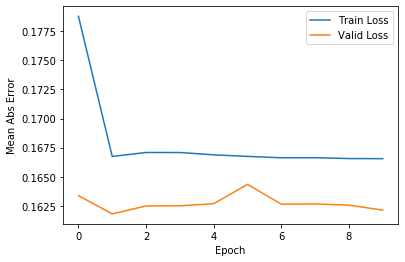

In [159]:
model = build_model()

4

history = model.fit(Train_MV_block, Train_WAV_block, batch_size = 1024, epochs = EPOCHS, validation_data = (Valid_MV_block, Valid_WAV_block), verbose = 0, callbacks = [early_stop, PrintDot()])
plot_history(history)

In [21]:
#test_predictions = model.predict(Test_MV_block)
#test_predictions = test_predictions * std_out + mean_out
#Test_MV_block = Test_WAV_block[:,0:63]
print(Test_MV_block)

test_predictions = model.predict(Test_MV_block)

mgc_head = test_predictions[:, 0:mgc_dim]
lf0_head = test_predictions[:, mgc_dim*3:mgc_dim*3+lf0_dim]
vuv_head = test_predictions[:, mgc_dim*3+lf0_dim*3:mgc_dim*3+lf0_dim*3+1]
bap_head = test_predictions[:, mgc_dim*3+lf0_dim*3+1:mgc_dim*3+lf0_dim*3+1+bap_dim]


mgc_ref = Test_WAV_block[:, 0:mgc_dim]
lf0_ref = Test_WAV_block[:, mgc_dim*3:mgc_dim*3+lf0_dim]
vuv_ref = Test_WAV_block[:, mgc_dim*3+lf0_dim*3:mgc_dim*3+lf0_dim*3+1]
bap_ref = Test_WAV_block[:, mgc_dim*3+lf0_dim*3+1:mgc_dim*3+lf0_dim*3+1+bap_dim]

[[-3.7540199e+01  1.1181000e+01 -3.1577001e+00 ...  2.2714901e+00
   2.6046376e+00  5.0570762e-01]
 [-3.7506916e+01  1.1241111e+01 -3.1297190e+00 ... -1.8312257e-02
  -3.2548774e-02 -7.2465450e-02]
 [-3.7470348e+01  1.1327316e+01 -3.1302817e+00 ...  6.9486037e-02
   4.0286019e-02  1.2406587e-01]
 ...
 [-3.5996899e+01  1.3103700e+01 -3.5511000e+00 ... -2.8800000e-02
   1.5799999e-02  1.1340000e-01]
 [-3.6019600e+01  1.3157400e+01 -3.4094000e+00 ...  3.0500000e-02
  -1.6200000e-02 -1.3440000e-01]
 [-3.5951000e+01  1.3227000e+01 -3.4030001e+00 ...  2.2390001e+00
   2.4410999e+00  5.9480000e-01]]


In [22]:
print(test_predictions)

[[ 0.15276851  0.10039644 -0.02406682 ...  0.00596739 -0.01962865
  -0.1566968 ]
 [ 0.09560335 -0.02709501 -0.01595998 ... -0.00641886 -0.00185775
  -0.04906384]
 [ 0.09539551 -0.02536725 -0.01638883 ... -0.00605282 -0.00164016
  -0.04858848]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [64]:
f0 = lf0_head.copy()
f0[vuv_head < 0.5] = 0
f0[np.nonzero(f0)] = np.exp(f0[np.nonzero(f0)])

spectrogram = pysptk.mc2sp(mgc_head, fftlen=fftlen, alpha=alpha)
aperiodicity = pyworld.decode_aperiodicity(bap_head.astype(np.float64), fs, fftlen)

generated_waveform = pyworld.synthesize(f0.flatten().astype(np.float64),
                                        spectrogram.astype(np.float64),
                                        aperiodicity.astype(np.float64),
                                        fs, frame_period)
Audio(generated_waveform.astype(np.float64), rate = fs)

In [96]:
def compute_mse(ref_data, gen_data):
    diff = (ref_data - gen_data) ** 2
    sum_diff = np.sum(diff, axis=1)
    sum_diff = np.sqrt(sum_diff)       # ** 0.5
    sum_diff = np.sum(sum_diff, axis=0)

    return  sum_diff
  
def compute_f0_mse(ref_data, gen_data):
  ref_vuv_vector = np.zeros((ref_data.size, 1))
  gen_vuv_vector = np.zeros((ref_data.size, 1))

  ref_vuv_vector[ref_data > 0.0] = 1.0
  gen_vuv_vector[gen_data > 0.0] = 1.0

  sum_ref_gen_vector = ref_vuv_vector + gen_vuv_vector
  voiced_ref_data = ref_data[sum_ref_gen_vector == 2.0]
  voiced_gen_data = gen_data[sum_ref_gen_vector == 2.0]
  voiced_frame_number = voiced_gen_data.size

  f0_mse = np.sum(((np.exp(voiced_ref_data) - np.exp(voiced_gen_data)) ** 2))
#        f0_mse = numpy.sum((((voiced_ref_data) - (voiced_gen_data)) ** 2))

  vuv_error_vector = sum_ref_gen_vector[sum_ref_gen_vector == 0.0]
  vuv_error = np.sum(sum_ref_gen_vector[sum_ref_gen_vector == 1.0])

  return  f0_mse, vuv_error, voiced_frame_number

from nnmnkwii.metrics import melcd

MCD = melcd(mgc_head[:,1:mgc_dim], mgc_ref[:,1:mgc_dim], lengths=None)

bap_mse = compute_mse(bap_head, bap_ref) / bap_ref.shape[0]

BAP = bap_mse /10

f0_mse, vuverror, voiced_frame_number = compute_f0_mse(lf0_head, lf0_ref)

f0_RMSE = np.sqrt( f0_mse / lf0_ref.shape[0] )

vuv_head[vuv_head >= 0.5] = 1
vuv_head[vuv_head < 0.5] = 0

error_count = vuv_head + vuv_ref


error_num = np.count_nonzero(error_count == 1)
VUV = error_num / vuv_ref.shape[0]

print(MCD)
print(BAP)
print(f0_RMSE)
print(VUV)

12.712015254705838
0.34352234010489724
172.67542396051695
0.5504183179216204
